In [ ]:
from typing import Optional
from pyddeeg.utils.postprocessing.reorganize_rqa_results import reorganize_rqa_results

import os
import numpy as np

# Set input and output paths
INPUT_PATH: str = "/home/mario/Python/Datasets/EEG/timeseries/processed/rqa/raw"
# By default, save to the same directory
OUTPUT_PATH: Optional[str] = "/home/mario/Python/Datasets/EEG/timeseries/processed/rqa"

output_files =[f for f in os.listdir(OUTPUT_PATH) 
               if 
               os.path.isfile(os.path.join(OUTPUT_PATH, f)) 
               and (
                   f.startswith("CT_UP") or
                   f.startswith("CT_DOWN") or
                   f.startswith("DD_UP") or 
                   f.startswith("DD_DOWN")
               )]

if len(output_files) == 0:
    print("No processed files found in the output directory. Reorganizing RQA results.")
    # Process RQA data and get dictionary with file paths
    result_files = reorganize_rqa_results(
        path=INPUT_PATH,
        output_path=OUTPUT_PATH
    )
else:
    print("There are already processed files in the output directory. Skipping reorganization.")
    result_files = {file.strip("_rqa_processed.npz"): os.path.join(OUTPUT_PATH, file) for file in output_files}
    
# Display the results
print("Processed RQA data files:")
for file_type, file_path in result_files.items():
    print(f"- {file_type}: {file_path}")
"""    
print("Data:")
data = {}
for file_type, file_path in result_files.items():
    file_content = np.load(file_path)['rqa_metrics']
    data[file_type] = file_content
    print(f"- {file_type}: {file_content.shape}")
"""

There are already processed files in the output directory. Skipping reorganization.
Processed RQA data files:
- CT_DOWN: /home/mario/Python/Datasets/EEG/timeseries/processed/rqa/CT_DOWN_rqa_processed.npz
- DD_UP: /home/mario/Python/Datasets/EEG/timeseries/processed/rqa/DD_UP_rqa_processed.npz
- CT_UP: /home/mario/Python/Datasets/EEG/timeseries/processed/rqa/CT_UP_rqa_processed.npz
- DD_DOWN: /home/mario/Python/Datasets/EEG/timeseries/processed/rqa/DD_DOWN_rqa_processed.npz
Data:
- CT_DOWN: (34, 32, 5, 9701, 15)
- DD_UP: (15, 32, 5, 9701, 15)
- CT_UP: (34, 32, 5, 9701, 15)


In [13]:
import os
import numpy as np
path_t7 = "/home/mario/Python/Datasets/EEG/timeseries/processed/rqa/raw/rqa_ch_T7_20250327_185616"
output_files = {
    f.replace("_rqa_results.npz", ""): 
        np.load(os.path.join(path_t7, f))["rqa_metrics"]
    for f in os.listdir(path_t7) 
    if os.path.isfile(os.path.join(path_t7, f)) 
    and f.endswith(".npz")
}
[print(f"{f}: {output_files.get(f).shape}") for f in output_files.keys()]

CT_DOWN_T7: (34, 1, 5, 9701, 15)
CT_UP_T7: (34, 1, 5, 9701, 15)
DD_DOWN_T7: (15, 1, 5, 9701, 15)
DD_UP_T7: (15, 1, 5, 9701, 15)


[None, None, None, None]

In [17]:
def normalize_rqa_metrics(patient_idx, band_idx):
    """
    Normalize RQA metrics for a specific patient and frequency band between -1 and 1.
    
    Parameters:
    - patient_idx (int): Patient index (0-33)
    - band_idx (int): Frequency band index (0-4)
    
    Returns:
    - dict: Dictionary containing normalized metrics for each condition
    """
    normalized_data = {}
    
    # Process each condition if the patient index is valid
    for condition, data in output_files.items():
        # Check if patient index is valid for this condition
        if patient_idx < data.shape[0]:
            # Extract data for this patient and band (shape: 9701, 15)
            patient_band_data = data[patient_idx, 0, band_idx, :, :]
            
            # Normalize each metric independently
            normalized_metrics = np.zeros_like(patient_band_data, dtype=float)
            
            for metric_idx in range(15):
                metric_values = patient_band_data[:, metric_idx]
                min_val = np.min(metric_values)
                max_val = np.max(metric_values)
                
                # Avoid division by zero
                if max_val == min_val:
                    normalized_metrics[:, metric_idx] = 0
                else:
                    # Scale to [-1, 1]
                    normalized_metrics[:, metric_idx] = 2 * (metric_values - min_val) / (max_val - min_val) - 1
            
            normalized_data[condition] = normalized_metrics
        else:
            print(f"Patient index {patient_idx} is out of range for condition {condition}")
    
    return normalized_data

# Example usage
patient = 0  # Select patient index
band = 4     # Select frequency band index
normalized_data = normalize_rqa_metrics(patient, band)

# Visualize results
for condition, data in normalized_data.items():
    print(f"{condition}: {data.shape}")
    # Optionally show statistics for verification
    print(f"  Min: {np.min(data)}, Max: {np.max(data)}")

CT_DOWN_T7: (9701, 15)
  Min: -1.0, Max: 1.0
CT_UP_T7: (9701, 15)
  Min: -1.0, Max: 1.0
DD_DOWN_T7: (9701, 15)
  Min: -1.0, Max: 1.0
DD_UP_T7: (9701, 15)
  Min: -1.0, Max: 1.0


<Figure size 2000x1500 with 0 Axes>

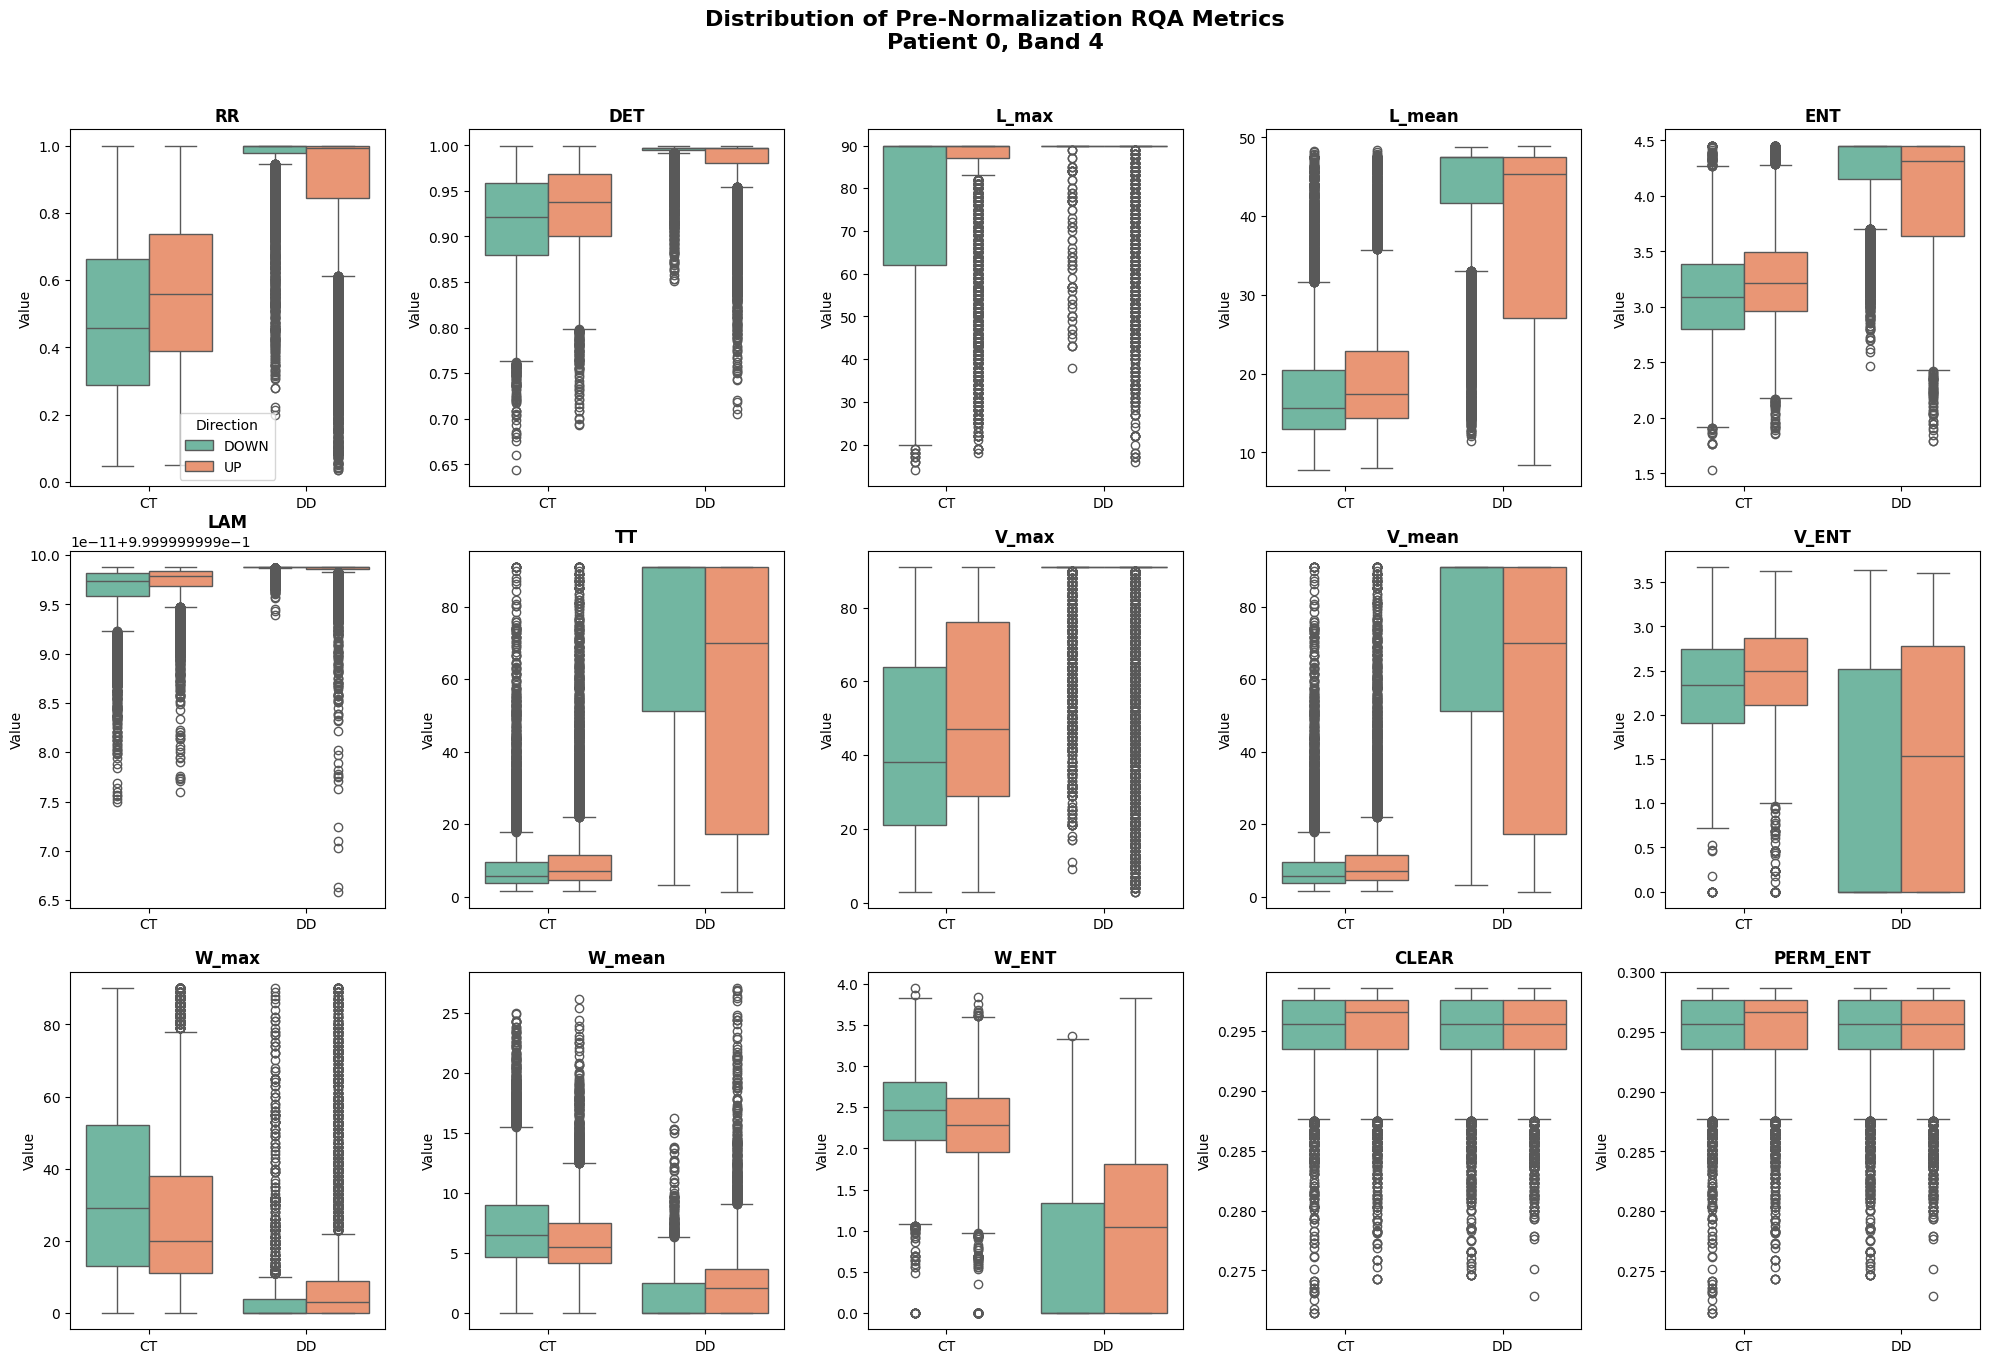

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to extract pre-normalization data for a specific patient and band
def extract_original_data(patient_idx, band_idx):
    """Extract original RQA metrics (before normalization) for a patient and band"""
    
    data_dict = {}
    
    for condition, data_array in output_files.items():
        # Check if patient index is valid for this condition
        if patient_idx < data_array.shape[0]:
            # Extract data for this patient and band (shape: 9701, 15)
            data_dict[condition] = data_array[patient_idx, 0, band_idx, :, :]
        else:
            print(f"Patient index {patient_idx} is out of range for condition {condition}")
    
    return data_dict

# Get original data
original_data = extract_original_data(patient, band)

# Create a long-form DataFrame for easier plotting with seaborn
df_list = []

for condition, data in original_data.items():
    # For each time point and metric
    for t in range(data.shape[0]):
        for m in range(data.shape[1]):
            group = "CT" if condition.startswith("CT") else "DD"
            direction = "UP" if "UP" in condition else "DOWN"
            
            df_list.append({
                'Group': group,
                'Direction': direction,
                'Metric': metric_names[m],
                'Value': data[t, m]
            })

df = pd.DataFrame(df_list)

# Create figure for boxplots
plt.figure(figsize=(20, 15))

# Set up grid of subplots (3x5 for 15 metrics)
fig, axes = plt.subplots(3, 5, figsize=(20, 15), sharex=False)
axes = axes.flatten()

# Plot each metric in its own subplot
for i, metric in enumerate(metric_names):
    ax = axes[i]
    
    # Filter data for this metric
    metric_df = df[df['Metric'] == metric]
    
    # Create boxplot
    sns.boxplot(
        x='Group', 
        y='Value', 
        hue='Direction',
        data=metric_df,
        ax=ax,
        palette="Set2"
    )
    
    ax.set_title(f"{metric}", fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=0)
    
    # Only show legend for the first plot
    if i != 0:
        ax.get_legend().remove()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)

# Add super title
plt.suptitle(f'Distribution of Pre-Normalization RQA Metrics\nPatient {patient}, Band {band}', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

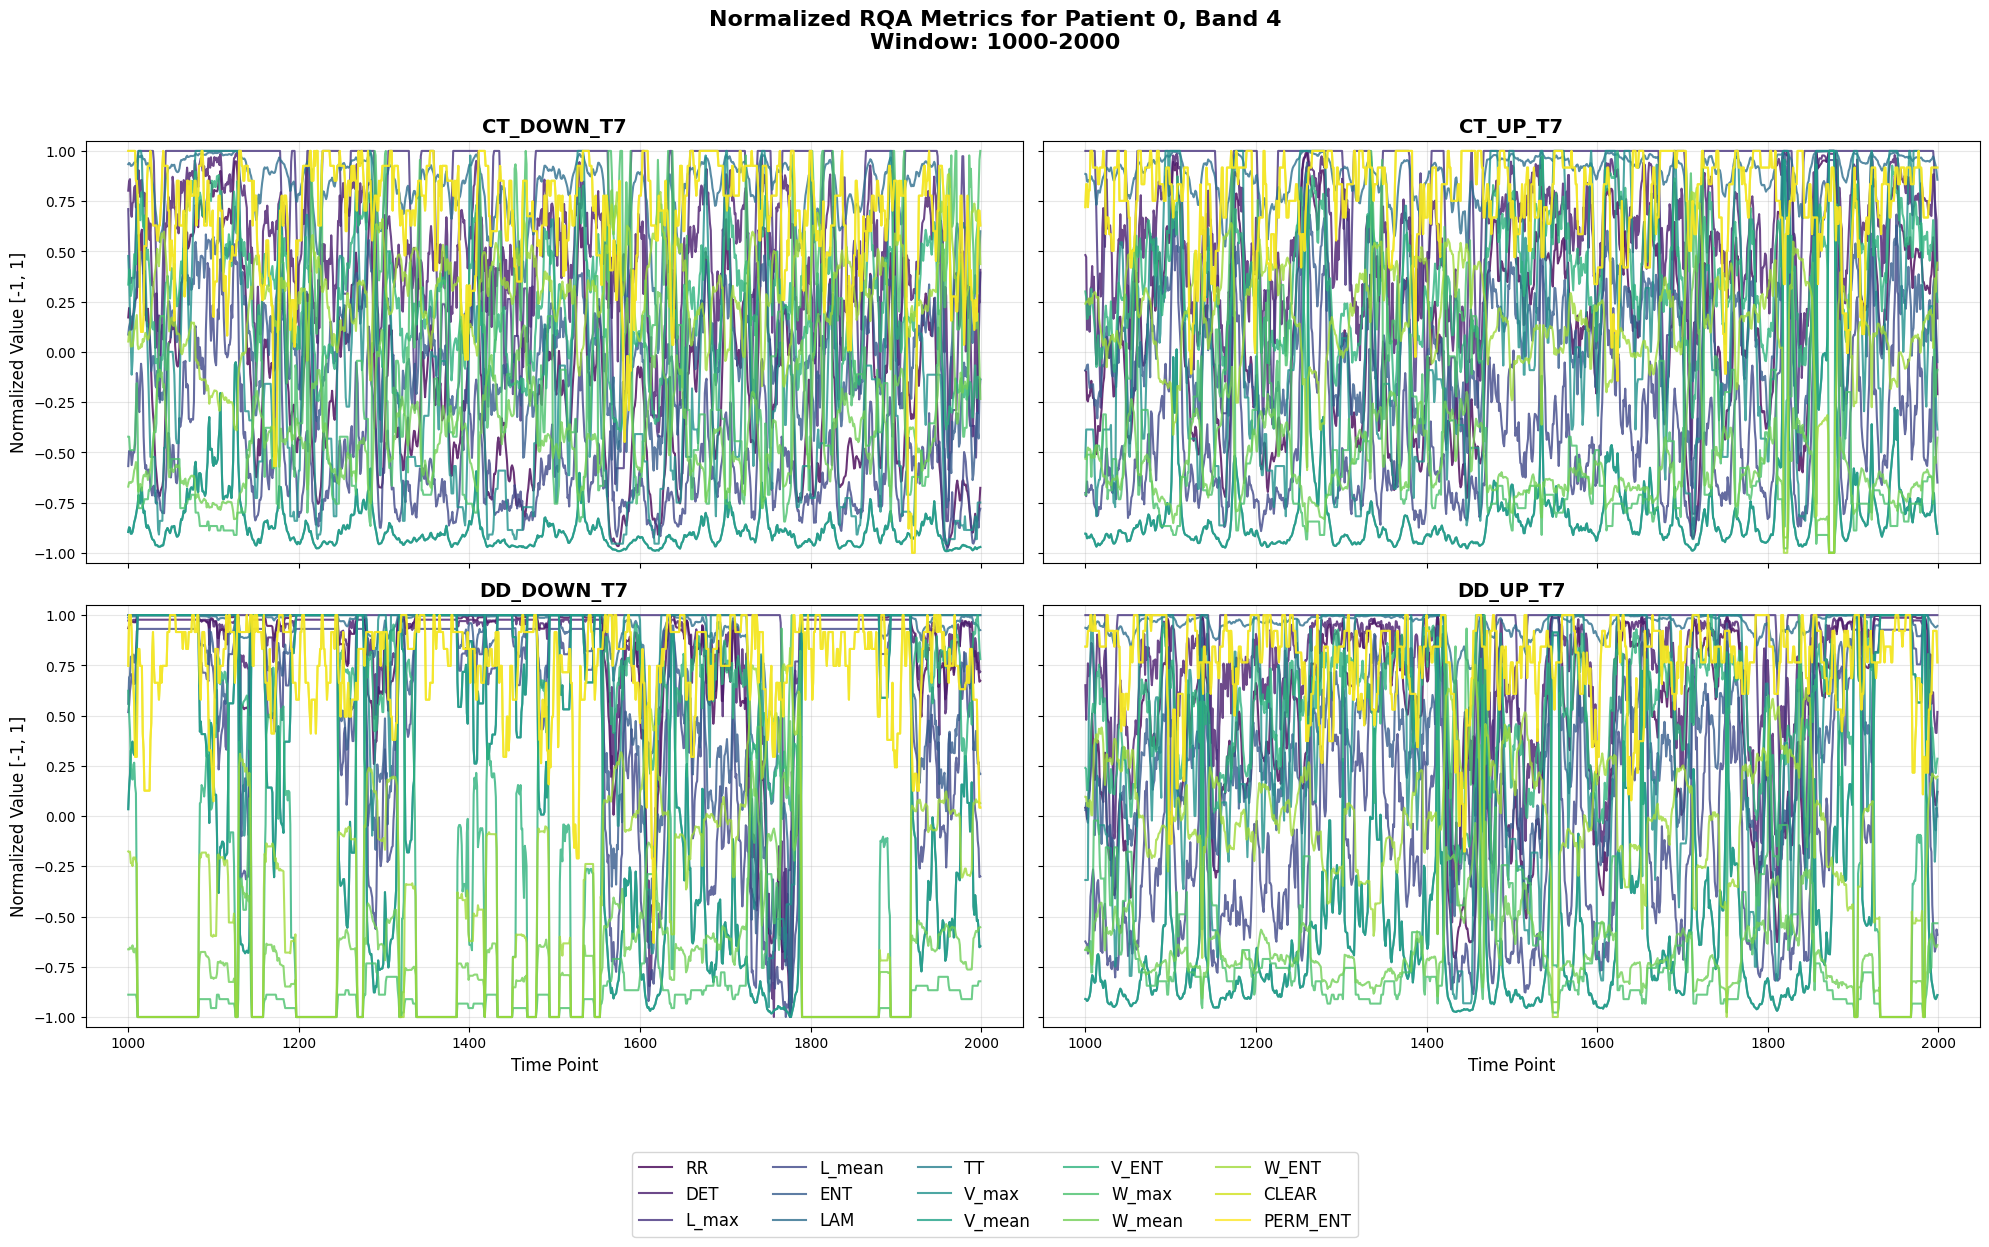

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define the real RQA metric names
metric_names = ["RR", "DET", "L_max", "L_mean", "ENT", "LAM", 
                "TT", "V_max", "V_mean", "V_ENT", 
                "W_max", "W_mean", "W_ENT", "CLEAR", "PERM_ENT"]

# If there's a 15th metric not named in the list
if len(metric_names) < 15:
    metric_names.append(f"Metric {len(metric_names)+1}")

# Window parameters - customize these values as needed
window_start = 1000  # Start index of the window
window_end = 2000    # End index of the window

# Create figure with shared x and y axes
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to make indexing easier

# Color map for metrics
colors = plt.cm.viridis(np.linspace(0, 1, 15))

# Plot each condition in its own subplot
for i, (condition, data) in enumerate(normalized_data.items()):
    ax = axes[i]
    
    # Make sure window indices are within bounds
    start_idx = max(0, min(window_start, data.shape[0]-1))
    end_idx = max(start_idx+1, min(window_end, data.shape[0]))
    
    # Get windowed data
    windowed_data = data[start_idx:end_idx, :]
    x_values = np.arange(start_idx, end_idx)
    
    # Plot each metric
    for j in range(min(15, len(metric_names))):
        ax.plot(x_values, windowed_data[:, j], color=colors[j], 
                label=metric_names[j] if i == 0 else "", 
                alpha=0.8, linewidth=1.5)
    
    ax.set_title(f"{condition}", fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Only add x-label to bottom plots
    if i >= 2:
        ax.set_xlabel('Time Point', fontsize=12)
    
    # Only add y-label to left plots
    if i % 2 == 0:
        ax.set_ylabel('Normalized Value [-1, 1]', fontsize=12)

# Set common y limits
for ax in axes:
    ax.set_ylim(-1.05, 1.05)

# Common legend outside the subplots - moved further down
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=12,
          bbox_to_anchor=(0.5, -0.05))

plt.suptitle(f'Normalized RQA Metrics for Patient {patient}, Band {band}\n'
             f'Window: {window_start}-{window_end}', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Adjusted bottom margin for legend
plt.show()